<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.851 · Tipología y ciclo de vida de los datos · PEC4</p>
<p style="margin: 0; text-align:right;">2019-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA 2: Limpieza y Análisis de datos

Alumnos:

 - Víctor Colomé 
 - Carlos Marcos 



## Tabla de Contenidos
* Descripción del Dataset
* Lectura de los datos
* Comprobación de valores nulos
* Análisis exploratorio
* Selección/Reducción
* Discretización
* Normalización
* Identificación y tratamiento de valores extremos
* Clasificación

# Descripción del Dataset

El juego de datos elegido es el Adult Data set (https://archive.ics.uci.edu/ml/datasets/adult), también conocido como el "Censo de ingresos". Éste consta de 48842 observaciones y 14 variables, las cuales se dividen en 13 variables independientes de todo tipo (continuas, categóricas, etc) y una variable dependiente referida a los ingresos con dos posibles valores: >50K y <=50K. El objetivo original del juego de datos fue predecir en base a las variables dependientes si una persona cobraría más de 50K al año.
En nuestro caso nos parece interesante porque es uno de los pocos juegos de datos públicos que permiten el estudio de ingresos en base a otras variables. Trataremos en esta práctica de obtener algunas conclusiones en base a estos datos y siempre pivotando sobre los ingresos como variable dependiente u objetivo, es decir, la columna "income" del juego de datos.

# Lectura de los datos
A continuación, leemos los datos directamente del sitio web. Durante la lectura especificamos que los datos iguales a ? sean marcados como "NAN", para luego poder identificarlos fácilmente.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# We describe the known N/A values to the parse so we can deal with them later 
df = pd.read_csv(url, na_values=['?'], skipinitialspace=True)
# Taken from http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
df.columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation",
              "relationship", "race", "sex", "capital_gain", "capital_loss", "hour_per_week", "native_country",
              "income"]
print(df.head())


   age         workclass  fnlwgt  education  education_num  \
0   50  Self-emp-not-inc   83311  Bachelors             13   
1   38           Private  215646    HS-grad              9   
2   53           Private  234721       11th              7   
3   28           Private  338409  Bachelors             13   
4   37           Private  284582    Masters             14   

       marital_status         occupation   relationship   race     sex  \
0  Married-civ-spouse    Exec-managerial        Husband  White    Male   
1            Divorced  Handlers-cleaners  Not-in-family  White    Male   
2  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
3  Married-civ-spouse     Prof-specialty           Wife  Black  Female   
4  Married-civ-spouse    Exec-managerial           Wife  White  Female   

   capital_gain  capital_loss  hour_per_week native_country income  
0             0             0             13  United-States  <=50K  
1             0             0             40

# Comprobación de valores nulos
Lo primero antes de empezar a trabajar es comprobar si existen valores nulos y tratarlos adecuadamente para poder tener el juego de datos limpio y completo. Para ello utilizamos la función isna

In [2]:
# Comprobar nulos antes de tratarlos
print(df.isna().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hour_per_week        0
native_country     583
income               0
dtype: int64


Vemos que tenemos valores nulos en 3 de las categorías: workclass, occupation y native_country. Lo que haremos será eliminar aquellos registros que tienen nulo en workclass y native_country. En cambio, en la clase occupation reemplazaremos esos nulos por una marca (UNKNOWN_OCCUPATION) que nos indique que no se conoce la ocupación.

In [3]:
# Delete workclass and native_country NaNs.
df.dropna(subset=["workclass", "native_country"], inplace=True)

# Replace occupation NaNs by UNKNOWN_OCCUPATION
df["occupation"] = df["occupation"].fillna("UNKNOWN_OCCUPATION")

# Comprobar nulos después de tratarlos
print(df.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hour_per_week     0
native_country    0
income            0
dtype: int64


# Análisis exploratorio

## Variables cuantitativas
Veamos la distribución general de las variables que tenemos en el juego de datos. Para ello, nos valdremos de la librería SeaBorn para mostrar las relaciones entre cada par de variables cuantitativas del dataset, así como para ver de manera sencilla y agrupada las distribuciones de cada variable

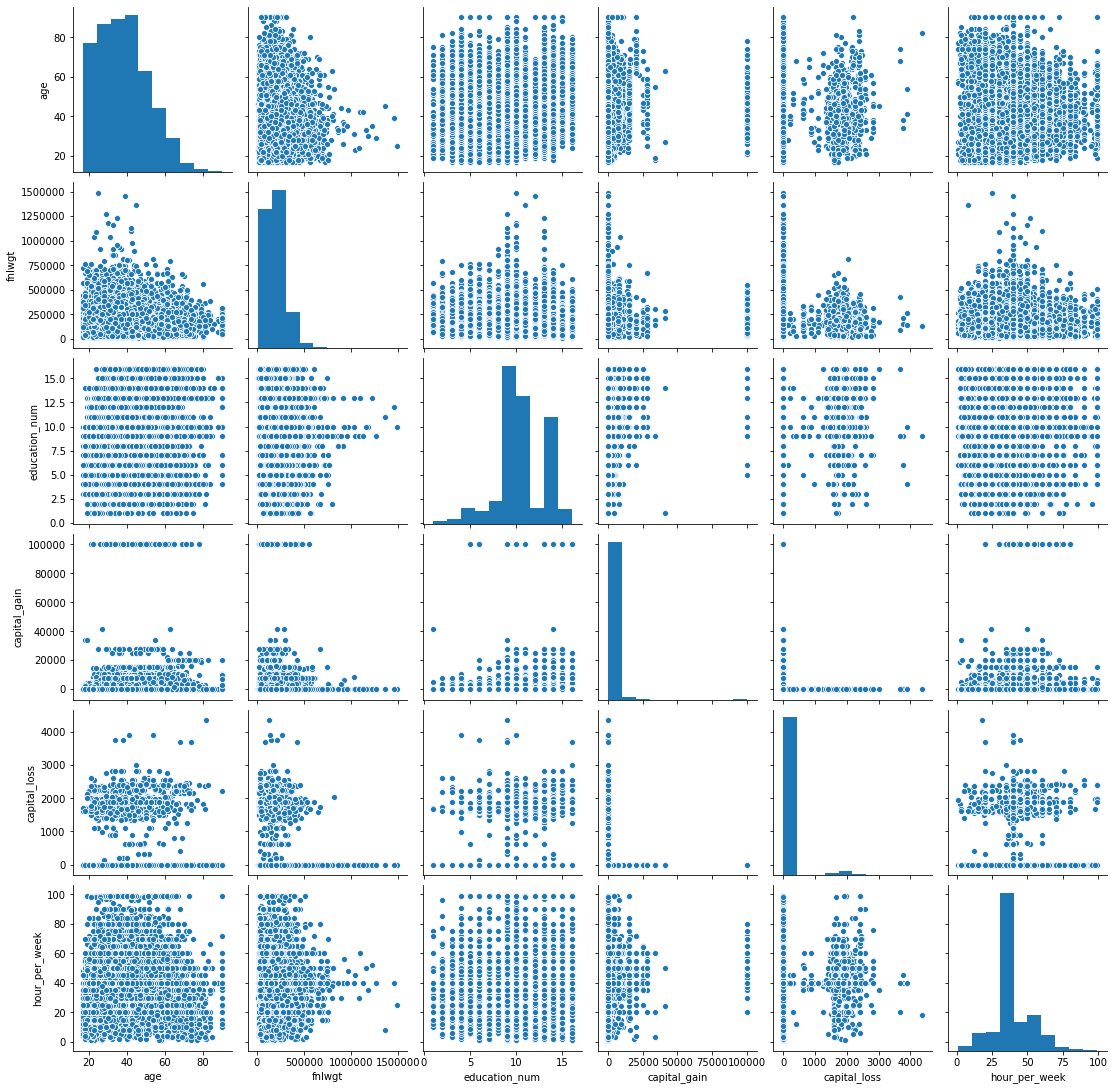

In [4]:
g = sns.pairplot(df)

Este gráfico nos aporta gran cantidad de información. En primer lugar, la diagonal nos da las distribuciones: gracias a ellas podemos ver que algunas variables, como age y fnlwgt, aparecen muy sesgadas hacia la izquierda. Otras, como capital_gain y capital_loss tienen la mayoría de sus valores distribuidos en un único valor (que en este caso es el 0). Por último, education_um y hour_per_week muestran distribuciones más o menos centradas: en el caso de las horas semanales, como es lógico, la mayoría de los valores están en 40 horas, y los demás valores siguen aproximadamente una Normal.

En cuanto a los gráficos por pares, estos nos pueden servir para detectar correlaciones entre variables, aunque en este caso esto no se aprecia a simple vista. Lo que sí se pueden ver es, por ejemplo, posibles valores extremos en capital_gain: estos aparecen como puntos separados de todos los demás en cada uno de los gráficos de la fila o columna correspondiente a esta variable. Más adelante, durante el análisis de outliers, veremos cómo actuar con respecto a estos valores.

Por último, el gráfico de hour_per_week por ejemplo no nos permite apreciar ninguna relación especial entre las horas semanales y la edad, indicándonos así que en principio no parece que exista ningún tipo de correlación entre ellas. Bien es cierto que el número de valores mostrado es tan alto que esto no es definitivo y por tanto tendrá que ser ratificado más adelante durante el análisis.



                    age    fnlwgt  education_num  capital_gain  capital_loss  \
age            1.000000 -0.076600       0.043848      0.080182      0.060221   
fnlwgt        -0.076600  1.000000      -0.044960      0.000415     -0.009774   
education_num  0.043848 -0.044960       1.000000      0.124423      0.079693   
capital_gain   0.080182  0.000415       0.124423      1.000000     -0.032221   
capital_loss   0.060221 -0.009774       0.079693     -0.032221      1.000000   
hour_per_week  0.101917 -0.022838       0.152656      0.080445      0.052454   

               hour_per_week  
age                 0.101917  
fnlwgt             -0.022838  
education_num       0.152656  
capital_gain        0.080445  
capital_loss        0.052454  
hour_per_week       1.000000  


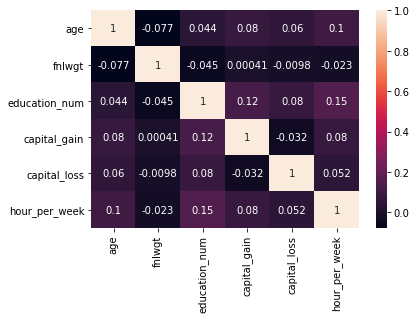

In [5]:
# PENDIENTE DE COLOCAR ESTO. ¿¿¿Lo dejamos aquí o ponemos un apartado específico de CORRELACION???

corr = df.corr()
print(corr)
sns.heatmap(corr, annot=True)
plt.show()



Nos proponemos analizar las relaciones entre las diferentes variables del conjunto de datos. 
Se partirá de las variables discretizadas, y se intentará hacer un pequeño análisis sobre el income según la ocupación 
y el sexo: intentaremos averiguar si hay desigualdad entre hombres y mujeres.

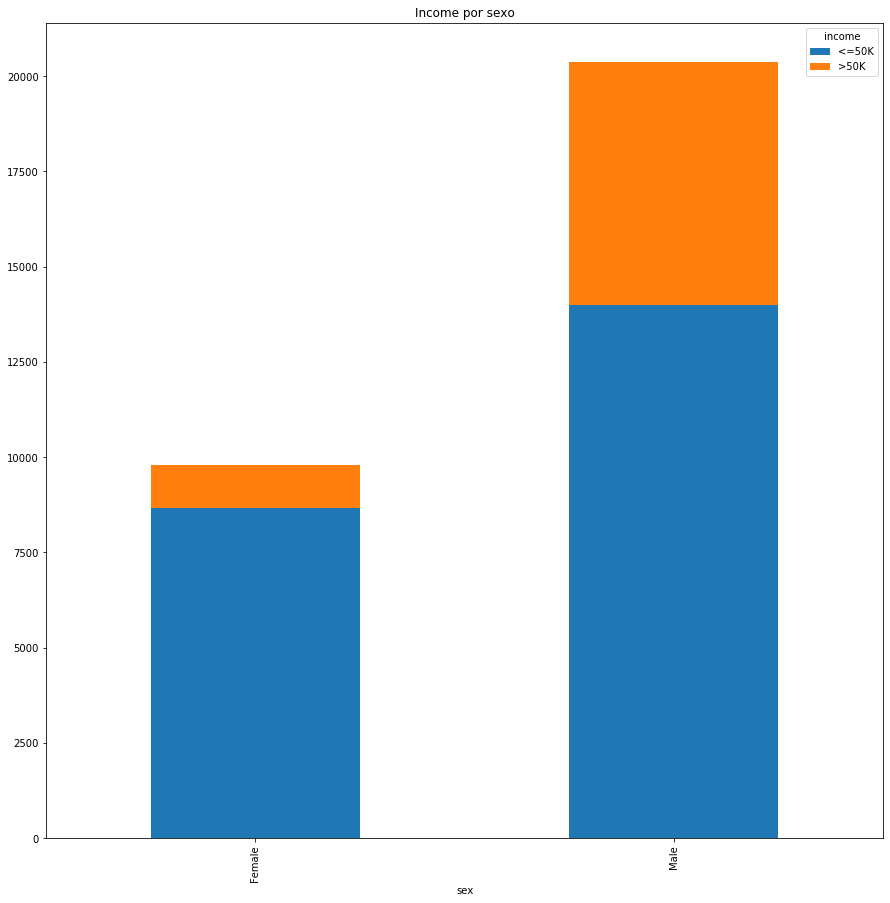

In [6]:
def stacked_bar(df: pd.DataFrame, index, columns, title):
    pivot_df = df[[index, columns]].pivot_table(index=index, columns=columns, aggfunc=len)
    pivot_df.plot.bar(stacked=True, figsize=(15, 15))
    plt.title(title)
    plt.show()


def histogram(df: pd.DataFrame, column, sex, title):
    df_aux = df.loc[df['sex'] == sex][column]
    plt.hist(df_aux, label=sex)
    plt.axvline(x=df_aux.mean(), c='r', label='Media = '+str(df_aux.mean()))
    plt.title(title)
    plt.legend()
    plt.show()


stacked_bar(df, 'sex', 'income', 'Income por sexo')

Se puede observar que hay más hombres que mujeres en este dataset: 20.380 hombres y 9.782 mujeres, 
aproximadamente un 50% más. También, observando el income, podemos ver que 8.670 mujeres tienen <=50K mientras que 
las 1.112 restantes tienen >50K; mientras los hombres 13.984 tienen un income <=50K y los 6.396 restantes >50K. 
Con lo que podemos extraer que el 11% de las mujeres y el 31% de los hombres tienen un income >50K. Esto podría parecer 
una desigualdad, pero no podemos extraer conclusiones precipitadas debido a que hay muchos factores que afectan al 
income.

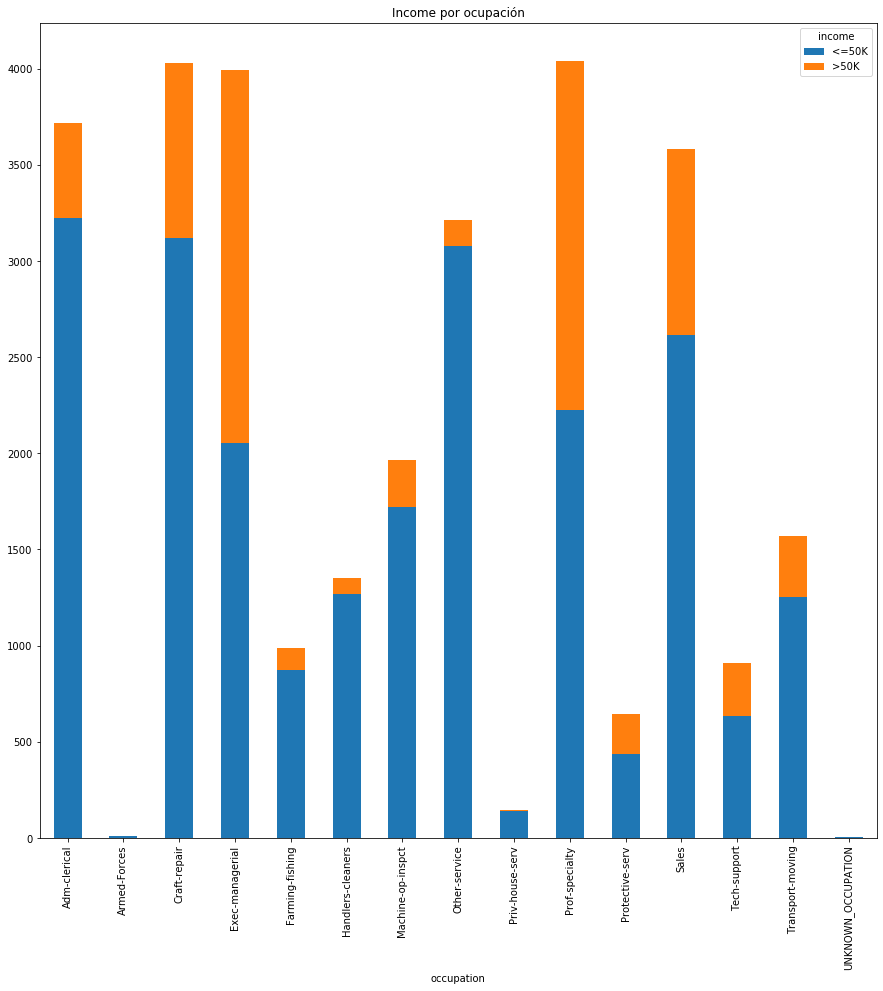

In [7]:
stacked_bar(df, 'occupation', 'income', 'Income por ocupación')

Podemos observar que los sueldos según el puesto varían, siendo el Exec-managerial y el Prof-specialty los que tienen
más % de income: 50% de gente con un income de >50K, mientras los demás tienen % bastante inferiores. 
Además las ocupaciones Armed-Forces y Priv-house-serv tienen poquisimas muestras (9 y 149 respectivamente, donde solo 1
de cada es >50K).

Ahora hay que ver qué puestos hay según sexo.

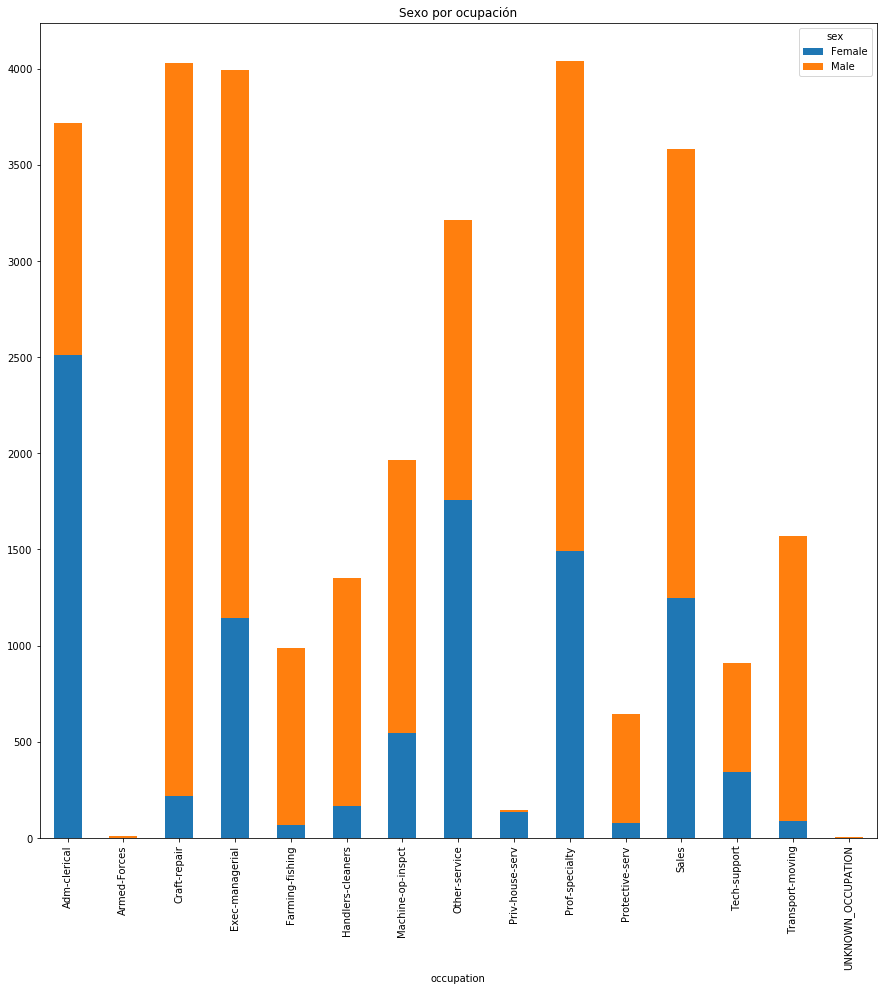

In [8]:
stacked_bar(df, 'occupation', 'sex', 'Sexo por ocupación')

Como se puede ver, en la mayoría de trabajos predomina el hombre excepto en Adm-clerical y Priv-house-serv donde hay un 
claro dominio de la mujer y en Other-service que hay aproximadamente un 50% de cada. Se puede observar también, que los 
puestos con más income hay más hombres que mujeres. De todas maneras, aún no podríamos determinar si hay desigualdad o 
no.

Para ello, miraremos un conjunto de gráficos con el income por sex por cada occupation:

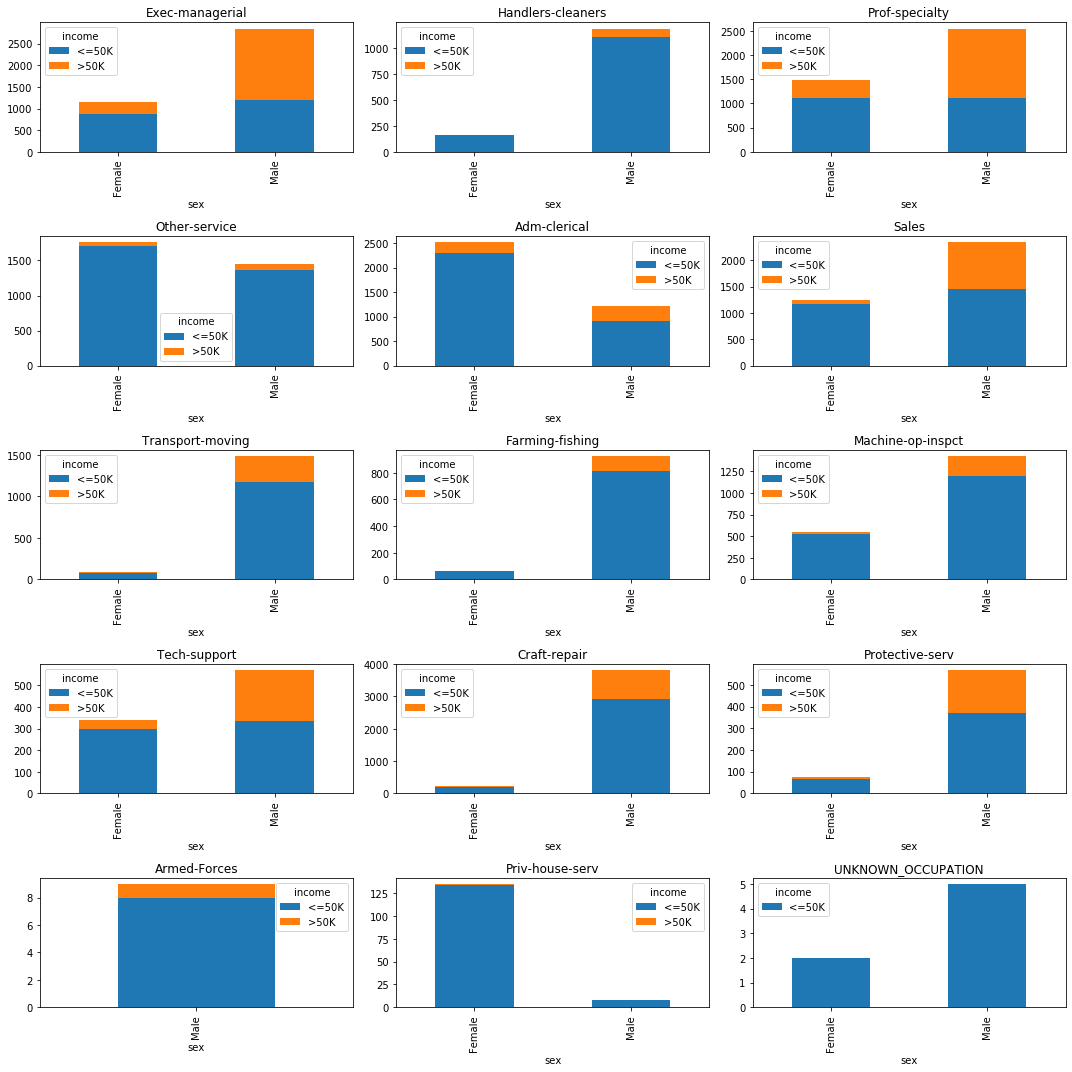

In [9]:
occupations = df['occupation'].unique()
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
i, j = 0, 0
for occ in occupations:
    df_occ = df.loc[df['occupation'] == occ]
    pivot_df = df_occ[['sex', 'income']].pivot_table(index='sex', columns='income', aggfunc=len)
    pivot_df.plot.bar(stacked=True, figsize=(15, 15), ax=axes[i, j])
    axes[i, j].set_title(occ)
    j += 1
    if j == 3:
        i += 1
        j = 0
# fig.suptitle('Todas las ocupaciones por sexo e income', fontsize=16)
# fig.subplots_adjust(top=0.88)
fig.tight_layout()
plt.show()


Se puede ver como los hombres tienen un income de >50K mayor que las mujeres en todos los ámbitos, incluso en los 
trabajos que predominan las mujeres como Adm-clerical. Esto ya empieza a dejar entrever que algo ocurre, si están en la 
misma empresa y ocupan el mismo puesto es una desigualdad salarial penada por ley (al menos en España), o que los 
hombres ocupen la mayoría de cargos importantes en la empresa y por tanto estén mejor pagados, la cual es la opción 
más probable, produciéndose así seguramente el denominado “techo de cristal”. La otra opción sería que trabajen en 
empresas distintas, y casualmente las mujeres en las que pagan menos.

De todas formas, sigue sin ser una estadística completa ya que faltan muchas variables por analizar 
(algunas de las cuales ni están en el dataset). Basándonos en el dataset, todavía hay factores determinantes en el
 por qué ésto puede ocurrir:

- La edad (age): normalmente cuanto mayor es el trabajador más cobra debido a su experiencia.
- Las horas de trabajo (hour_per_week): en un mismo puesto, cuanto más se trabaja más se cobra.
- La educación (education): muchas veces se paga más o menos dependiendo de la titulación, alguien con máster es más 
probable que cobre más que alguien con la carrera y éste que cobre más que alguien sin carrera.
- La raza (race) o el lugar de nacimiento (native_country): si hay racismo.
- etc…

Observemos algunas de estos aspectos:

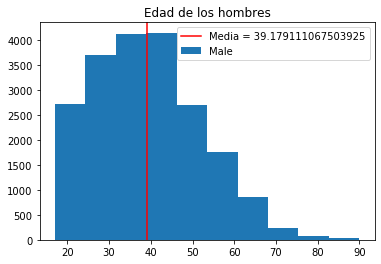

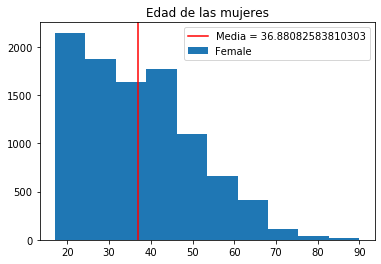

In [10]:
histogram(df, 'age', 'Male', 'Edad de los hombres')
histogram(df, 'age', 'Female', 'Edad de las mujeres')

La media de edad de los hombres es de 39,2 y la de las mujeres 36,8; bastante igualadas en general. 
En la distribución de la edad de los hombres se puede observar que la mayoría están comprendidos entre los 30 y los 40 
años; mientras las mujeres entre los 20 y los 40, sobre todo los 20, la edad con los sueldos más bajos generalmente.
Aunque se podría mirar más exhasutivamente, si los puestos donde pagan más hay mujeres jóvenes mientras los 
hombres son mayores y los puestos donde pagan menos hay mujeres mayores, no se entrará en tanto nivel de detalle.

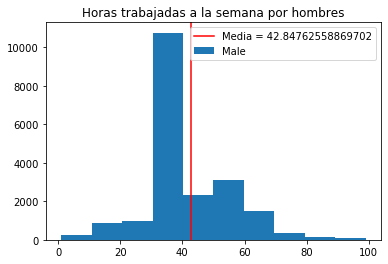

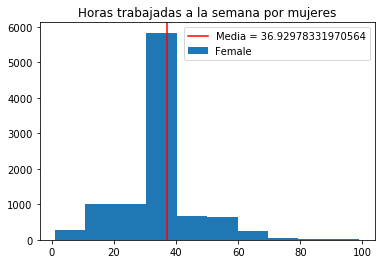

In [11]:
histogram(df, 'hour_per_week', 'Male', 'Horas trabajadas a la semana por hombres')
histogram(df, 'hour_per_week', 'Female', 'Horas trabajadas a la semana por mujeres')

Vemos que los hombres de media trabajan 42.8 horas mientras que las mujeres 36.9, lo cual puede ser un motivo que 
explicaría esta diferencia de income, así que hay que analizarlo.

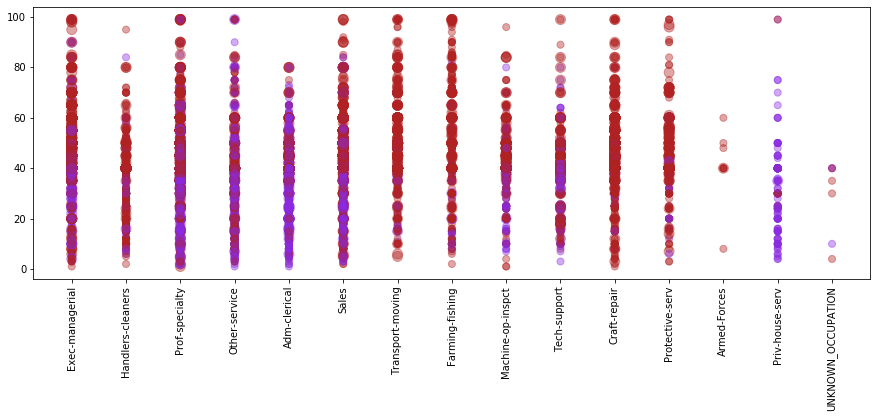

In [12]:
clr = {'Male': 'firebrick', 'Female': 'blueviolet'}
colors = df["sex"].apply(lambda x: clr[x])
szs = {'<=50K': 50, '>50K': 100}
sizes = df['income'].apply(lambda x: szs[x])

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df.occupation, df.hour_per_week, sizes=sizes, c=colors, alpha=0.4)
plt.xticks(rotation='vertical')
plt.show()
    

En este gráfico se puede ver que hay todo tipo income por hora trabajada en cada ocupación, incluso hay datos de gente 
que trabaja 1h a la semana y gente que trabaja 99h. Como puede ser complicado analizar este gráfico de manera visual, 
habrá que apoyarse en la siguiente tabla que contiene la media de horas por semana de cada ocupación que hace cada 
sexo por cada income:

                                 hour_per_week
                                          mean
occupation         income sex                 
Adm-clerical       <=50K  Female     36.722102
                          Male       37.885745
                   >50K   Female     37.349282
                          Male       43.363322
Armed-Forces       <=50K  Male       40.750000
                   >50K   Male       40.000000
Craft-repair       <=50K  Female     39.771574
                          Male       41.736068
                   >50K   Female     41.105263
                          Male       44.732283
Exec-managerial    <=50K  Female     40.938799
                          Male       44.086627
                   >50K   Female     43.144404
                          Male       48.003012
Farming-fishing    <=50K  Female     38.190476
                          Male       46.651048
                   >50K   Female     25.000000
                          Male       54.725664
Handlers-clea

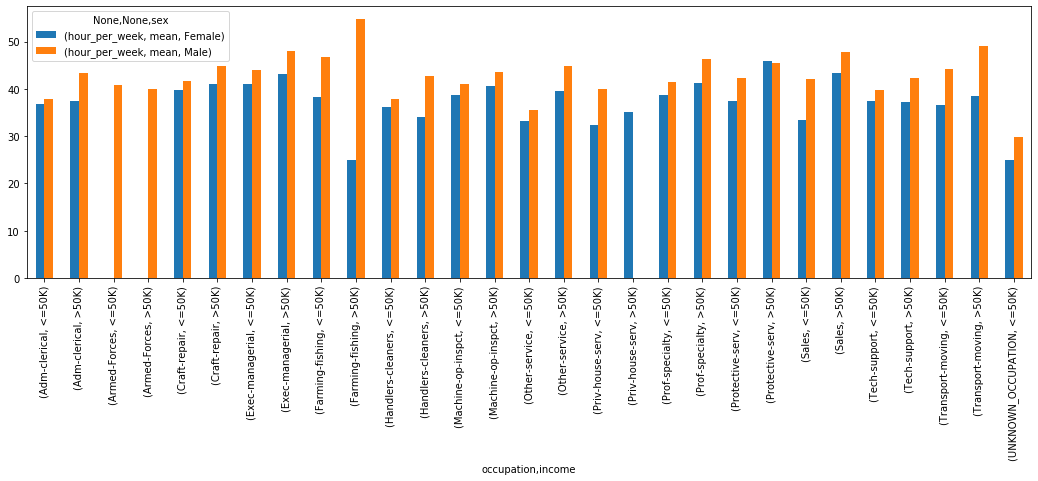

In [13]:
#grouped_multiple = df.groupby(['sex', 'occupation', 'income']).agg({'hour_per_week': ['mean']})
#print(grouped_multiple)
#grouped_multiple.unstack(fill_value=0).plot.bar(figsize=(18,5))
#pd.crosstab(df['sex'],df['occupation']).plot.bar()

#grouped_multiple = df.groupby(['occupation', 'sex', 'income']).agg({'hour_per_week': ['mean']})
#print(grouped_multiple)
#grouped_multiple.unstack(fill_value=0).plot.bar(figsize=(18,5), stacked=True)

grouped_multiple = df.groupby(['occupation', 'income', 'sex']).agg({'hour_per_week': ['mean']})
print(grouped_multiple)
grouped_multiple.unstack(fill_value=0).plot.bar(figsize=(18,5))



En esta tabla podemos observar que los hombres, a pesar de trabajar más horas semanalmente tienen un income menor que las 
mujeres de su misma ocupación. Esto se puede ver reflejado en ocupaciones como Adm-clerical, Craft-repair, 
Exec-managerial, Farming-fishing, Handlers-cleaners, Machine-op-inspct, Prof-specialty, Tech-support y 
Transport-moving, donde los hombres con un income <=50K trabajan más que las mujeres que tienen un income >50K. 
Además, en ocupaciones como Handlers-cleaners y Farming-fishing, las mujeres con menos income trabajan más que las 
que tienen más income.

En conclusión, aunque teniendo una perspectiva global de los datos parece que puede haber una desigualdad salarial 
entre hombres y mujeres, ésta no queda del todo reflejada cuando los miras más detenidamente debido a la mayor 
cantidad de horas trabajadas por los hombres en todas las ocupaciones, las cuales lo lógico es que se reflejen con un 
mayor income. Además, el problema planteado al principio del “techo de cristal” también queda puesto en duda debido a 
que, si nos basamos en una empresa basada en el meritaje, se recompensará a los trabajadores que hagan más horas 
(ya que en este dataset no hay otra manera de calcular el rendimiento).

De todas maneras, este estudio está muy limitado debido a que no se han usado todas las variables del dataset y además 
es un campo que necesitaría muchas más variables a tener en cuenta.

## Variables cualitativas
Veamos a continuación las variables cualitativas

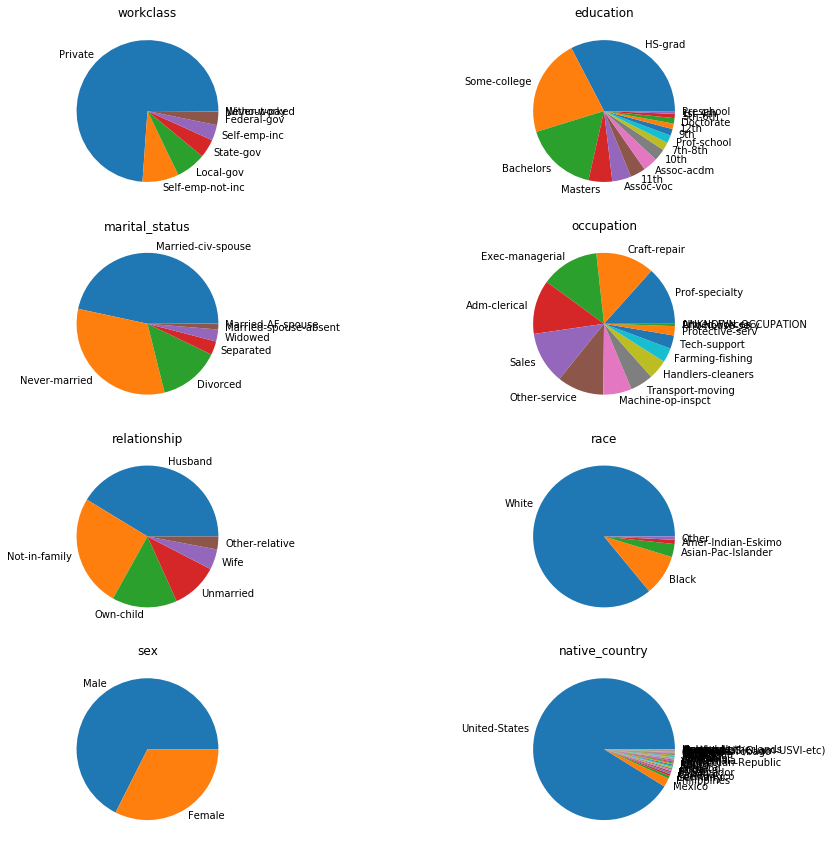

In [14]:

cNamesObj = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

conteo = df['workclass'].value_counts()

nrow = 4; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,15))

for ax,nom in zip(axs.reshape(-1), cNamesObj): 
    conteo = df[nom].value_counts()
    ax.pie(conteo, labels=conteo.index)
    ax.set_title(nom)


Indiquemos ahora lo más significativo que se ve en estos gráficos:
Vemos que la gran mayoría de los empleos de la muestra corresponden a la empresa privada, con más de 3/4 del total. La educación, en cambio, está distribuida más equitativamente entre las observaciones de nuestra muestra.
En el estado civil vemos que la mayoría de nuestras observaciones son de tipo casado o soltero, mientras que la variable "relationship" muestra una clara prevalencia de "Maridos" en nuestra muestra. La raza de nuestras observaciones es mayoritariamente blanca y hay una clara predominancia del número de hombres sobre el de mujeres. 
Sin embargo, el sesgo más claro se ve en la última variable: el país de origen, donde Estados Unidos agrupa casi la totalidad de las muestras. Debido a esto quizá sea más conveniente cambiar esta variable por una que nos indique si una observación es de EEUU o no, lo cual simplifica nuestro juego de datos a la vez que mantiene la información relevante. Se verá en apartados posteriores

# Selección/Reducción

Se ha decidido no realizar ningún método de selección o reducción ya que a la hora de comprobar la correlación no se ha visto ninguna correlación entre atributos significativa como para pensar que una reducción como la PCA podría mejorar el dataset.

# Discretización
La discretización consiste en la agrupación de valores en rangos significativos con el objetivo de simplificar el dataset. Veamos qué tipos de datos tenemos

In [15]:
print(df.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hour_per_week      int64
native_country    object
income            object
dtype: object


La edad parece un candidato ideal para la discretización:

In [16]:
print(df.describe()['age'])

count    30168.000000
mean        38.433738
std         13.136338
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64


In [17]:
df.age = pd.cut(df.age, bins=[16, 30, 50, 65, 90], labels=[0, 1, 2, 3])  # 0:"17-29", 1:"30-49", 2:"50-65", 3:"+65"
print(df.head())

  age         workclass  fnlwgt  education  education_num      marital_status  \
0   1  Self-emp-not-inc   83311  Bachelors             13  Married-civ-spouse   
1   1           Private  215646    HS-grad              9            Divorced   
2   2           Private  234721       11th              7  Married-civ-spouse   
3   0           Private  338409  Bachelors             13  Married-civ-spouse   
4   1           Private  284582    Masters             14  Married-civ-spouse   

          occupation   relationship   race     sex  capital_gain  \
0    Exec-managerial        Husband  White    Male             0   
1  Handlers-cleaners  Not-in-family  White    Male             0   
2  Handlers-cleaners        Husband  Black    Male             0   
3     Prof-specialty           Wife  Black  Female             0   
4    Exec-managerial           Wife  White  Female             0   

   capital_loss  hour_per_week native_country income  
0             0             13  United-States  <=

# Normalización

Con los datos ya preparados, podemos proceder a su normalización. Esto nos será útil más adelante para poder aplicar algoritmos de clasificación. Con este objetivo en mente, definiremos dos tipos de columnas: las que tienen valores categóricos y las que tienen valores numéricos. Las primeras las normalizaremos mediante OneHotEncoding, reemplazándolas por columnas dummies que contengan los posibles factores y 0/1 en función de si ese valor está o no presente. 
En cambio, para las columnas numéricas realizaremos un escalado normal con StandardScaler 

In [18]:
cNamesInt = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hour_per_week']
# The country column has many possible values, but the most common by far is "United-States", so we will resume
# the information transforming this variable into a True/False, and then getting the dummies. This way we keep
# most of the information present in original dataset and prevent having too many dummy columns
df['native_country'] = df['native_country']=='United-States'
df[cNamesObj] = df[cNamesObj].astype('category')
df = pd.get_dummies(df, columns=cNamesObj)
scaler = StandardScaler().fit(df[cNamesInt].values)
df[cNamesInt] = scaler.fit_transform(df[cNamesInt])
print(df.head())
print(df.dtypes)

        age    fnlwgt  education_num  capital_gain  capital_loss  \
0  0.133743 -1.007986       1.129100      -0.14742     -0.218563   
1  0.133743  0.244579      -0.439416      -0.14742     -0.218563   
2  1.446712  0.425126      -1.223674      -0.14742     -0.218563   
3 -1.179226  1.406544       1.129100      -0.14742     -0.218563   
4  0.133743  0.897066       1.521229      -0.14742     -0.218563   

   hour_per_week income  workclass_Federal-gov  workclass_Local-gov  \
0      -2.330856  <=50K                      0                    0   
1      -0.077480  <=50K                      0                    0   
2      -0.077480  <=50K                      0                    0   
3      -0.077480  <=50K                      0                    0   
4      -0.077480  <=50K                      0                    0   

   workclass_Never-worked  ...  relationship_Wife  race_Amer-Indian-Eskimo  \
0                       0  ...                  0                        0   
1       

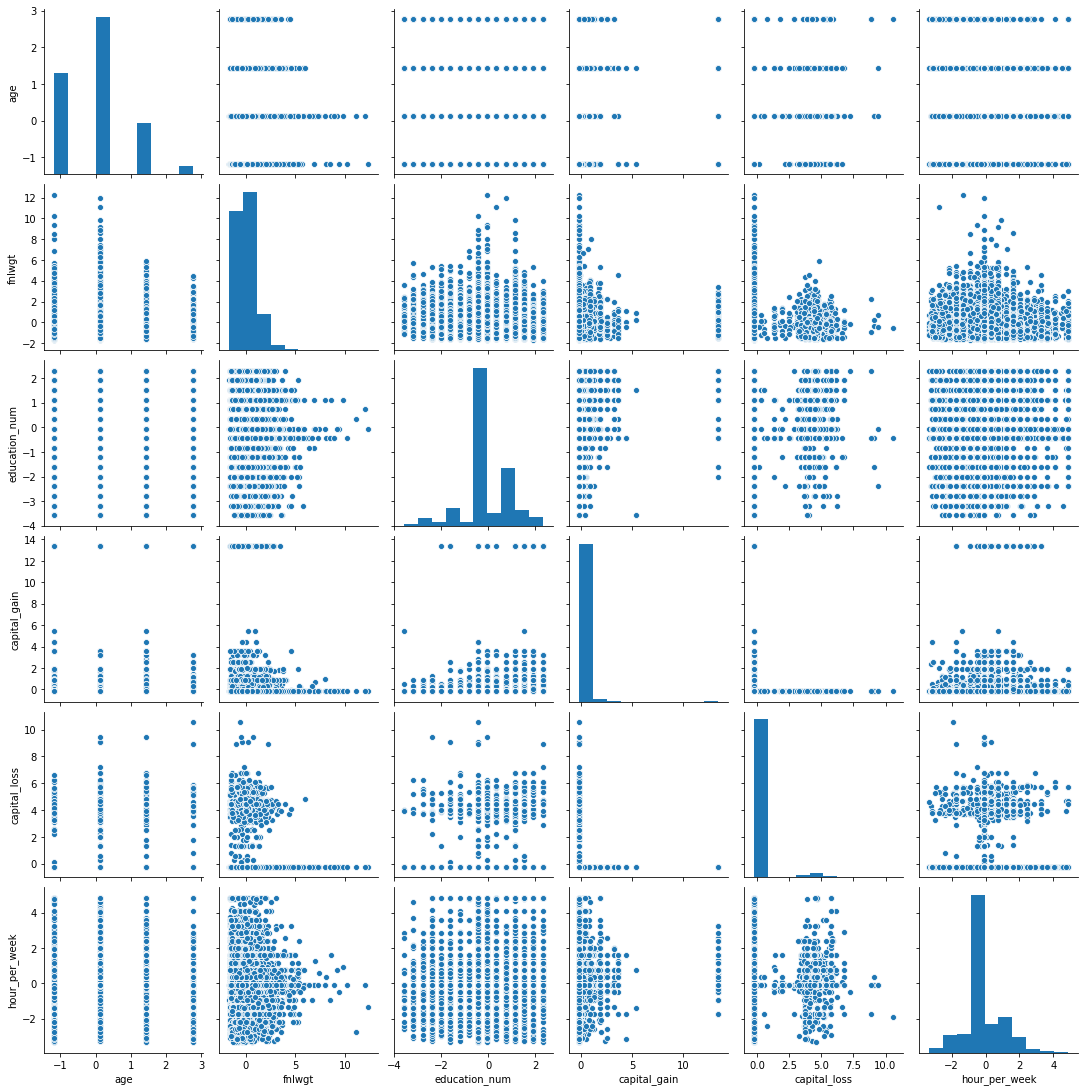

In [19]:
g = sns.pairplot(df[cNamesInt])

# Identificación y tratamiento de valores extremos
A continuación detectamos aquellos valores que son extremos y que por tanto deben ser tratados de manera especial.

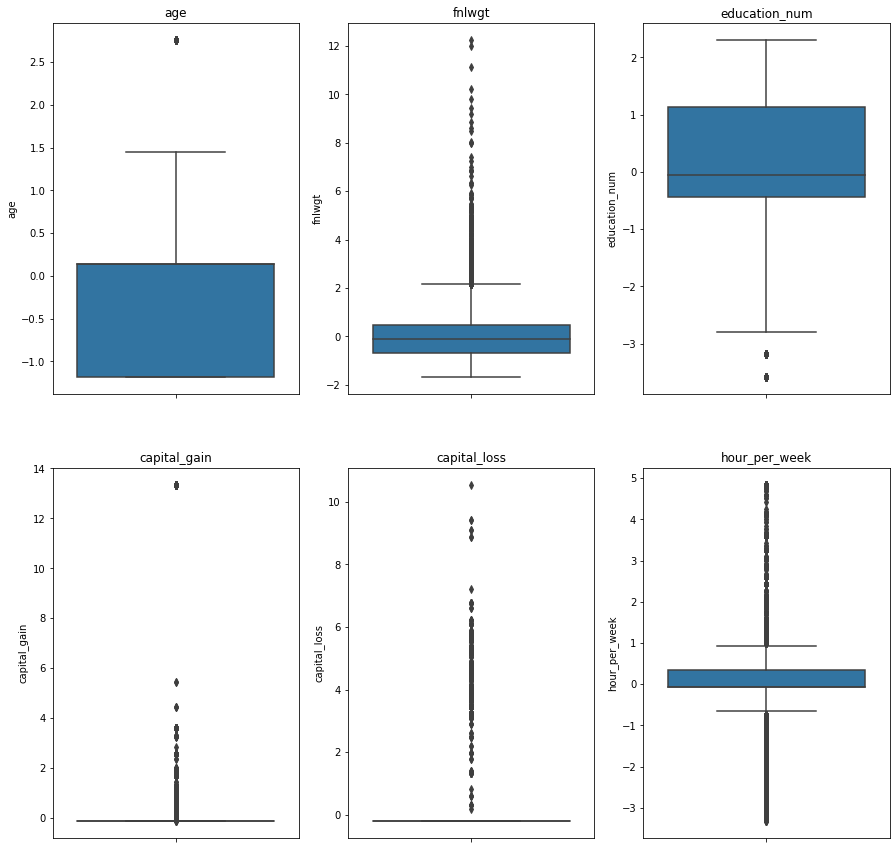

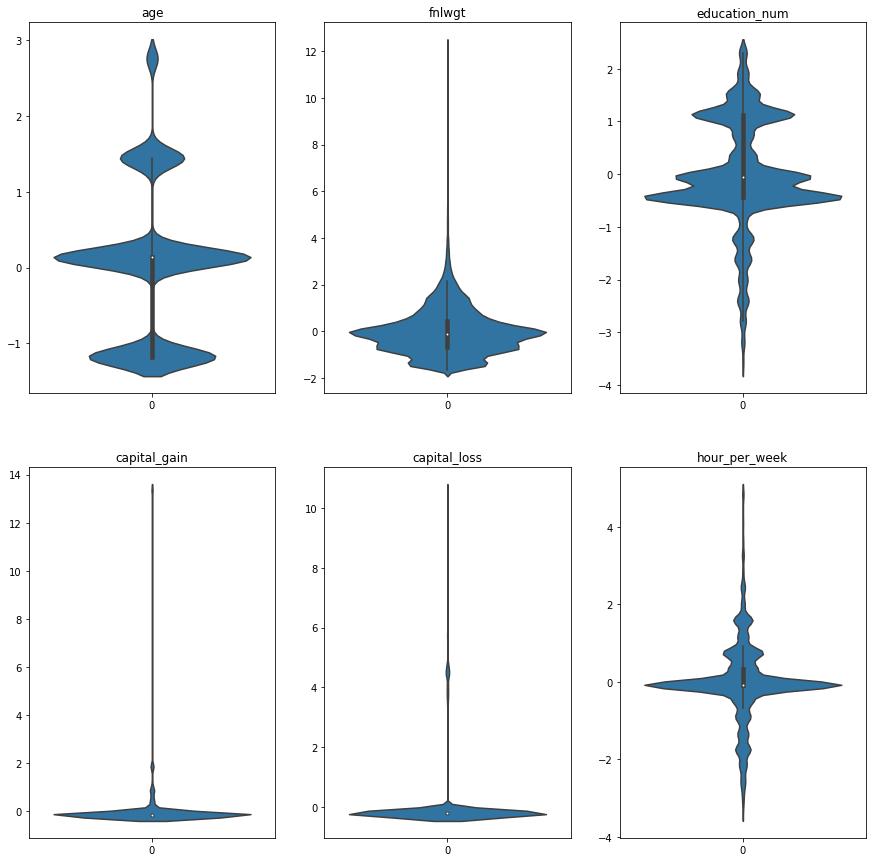

In [20]:
fig, axes1 = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
fig, axes2 = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
i, j = 0, 0
for col_name in df[cNamesInt].columns:
    if col_name != 'income':
        # Plot 1
        sns.boxplot(y=df[col_name], ax=axes1[i, j])
        axes1[i, j].set_title(col_name)
        # Plot 2
        sns.violinplot(data=df[col_name], ax=axes2[i, j])
        axes2[i, j].set_title(col_name)
        # Next ax
        j += 1
        if j == 3:
            i += 1
            j = 0
plt.show()

# Clasificación

Con los datos normalizados, veamos si podemos aplicar un algoritmo de clasificación para predecir si el income será mayor o menor que 50K en base a las demás variables.
Utilizaremos para ello un algoritmo de bagging basado en árboles de decisión llamado RandomForest, y dividimos el juego de datos en un 80% para entrenamiento y un 20% de prueba. Emplearemos una validación cruzada con 5 folds para evaluar el método.

Cross validation accuracy = 84.02390148127081%
Test accuracy : 84.36


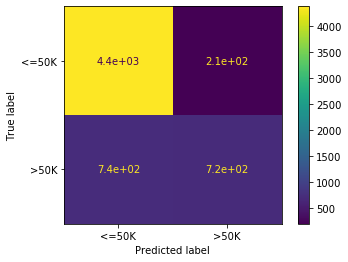

In [21]:
random_state = 0
X = df.drop(columns='income')
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
clf = RandomForestClassifier(max_depth=6, n_estimators=10, random_state=random_state)
clf.fit(X_train, y_train)

print('Cross validation accuracy = {}%'.format(cross_val_score(clf, X_test, y_test, cv=5).mean() * 100))
y_pred = clf.predict(X_test)
print("Test accuracy : %0.2f" % (accuracy_score(y_test, y_pred) * 100))
plot_confusion_matrix(clf, X_test, y_test)

Con el algoritmo de clasificación se ha conseguido una buena precisión, por lo que podríamos predecir con una alta seguridad el income de un individuo a partir de los diferentes atributos.

Con la matriz de confusión se puede observar que se han obtenido 740+210 falsos positivos, siendo más probable que un income de >50k lo clasifique como uno de <=50k.